# Exploring Enhanced SSIS Structure with SQL Semantics in Memgraph

This notebook focuses on understanding how SSIS components are represented in the enhanced graph with **SQL semantics metadata** - crucial for migration agents.

## 🆕 Enhanced Features for Migration
- **SQL Semantics Metadata**: Complete JOIN relationships, column aliases, transformations
- **Migration-Ready Queries**: Queries designed for migration agent consumption
- **Categories Table Validation**: Verify the Categories table extraction fix
- **Platform-Specific Insights**: Metadata organized for Spark, dbt, Pandas migration

## What We'll Learn
- SSIS package structure with SQL semantics
- How operations contain migration-critical SQL metadata
- JOIN relationships between tables (like Products ↔ Categories)
- Column aliases and transformations
- Data flow analysis with enhanced metadata

In [12]:
# Setup - same as notebook 01
import mgclient
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Connect to Memgraph
mg = mgclient.connect(host='localhost', port=7687, username='', password='')
print("✅ Connected to Memgraph")

def execute_query(query, description=None):
    """Execute a Cypher query and return results as DataFrame."""
    if description:
        print(f"\n🔍 {description}")
        print(f"Query: {query}")
        print("-" * 50)
    
    cursor = mg.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    
    if results:
        columns = [desc.name for desc in cursor.description] if cursor.description else ['result']
        df = pd.DataFrame(results, columns=columns)
        print(f"Found {len(df)} results")
        return df
    else:
        print("No results found.")
        return pd.DataFrame()

✅ Connected to Memgraph


## Part 1: SSIS Package Analysis

In [16]:
# Get detailed information about SSIS packages
packages_df = execute_query(
    """MATCH (p:Node {node_type: 'pipeline'}) 
       RETURN p.name as package_name, 
              p.id as package_id,
              p.properties as properties
       ORDER BY p.name""",
    "Detailed SSIS package information"
)

print(f"\n📦 Found {len(packages_df)} SSIS packages:")
for _, pkg in packages_df.iterrows():
    print(f"  • {pkg['package_name']}")
    
display(packages_df[['package_name', 'package_id']].head(30))


🔍 Detailed SSIS package information
Query: MATCH (p:Node {node_type: 'pipeline'}) 
       RETURN p.name as package_name, 
              p.id as package_id,
              p.properties as properties
       ORDER BY p.name
--------------------------------------------------
Found 18 results

📦 Found 18 SSIS packages:
  • Customer.dtsx
  • Emp.dtsx
  • Employee.dtsx
  • Fact.dtsx
  • Fact_orders.dtsx
  • Package.dtsx
  • Package1.dtsx
  • Package2.dtsx
  • Package3.dtsx
  • Package4.dtsx
  • Package5.dtsx
  • Product.dtsx
  • ShioInfo.dtsx
  • Ship_Info.dtsx
  • Shippers.dtsx
  • Suppliers.dtsx
  • factFinal.dtsx
  • northwind.dtsx


,package_name,package_id
0,Customer.dtsx,pipeline:Customer.dtsx
1,Emp.dtsx,pipeline:Emp.dtsx
2,Employee.dtsx,pipeline:Employee.dtsx
3,Fact.dtsx,pipeline:Fact.dtsx
4,Fact_orders.dtsx,pipeline:Fact_orders.dtsx
5,Package.dtsx,pipeline:Package.dtsx
6,Package1.dtsx,pipeline:Package1.dtsx
7,Package2.dtsx,pipeline:Package2.dtsx
8,Package3.dtsx,pipeline:Package3.dtsx
9,Package4.dtsx,pipeline:Package4.dtsx


In [14]:
# Look at package properties to understand what metadata is available
if not packages_df.empty:
    sample_package = packages_df.iloc[0]
    print(f"\n🔍 Sample Package Properties: {sample_package['package_name']}")
    print("=" * 60)
    
    try:
        properties = json.loads(sample_package['properties']) if isinstance(sample_package['properties'], str) else sample_package['properties']
        for key, value in properties.items():
            if isinstance(value, str) and len(value) > 100:
                print(f"{key}: {value[:100]}...")
            else:
                print(f"{key}: {value}")
    except Exception as e:
        print(f"Could not parse properties: {e}")
        print(f"Raw properties: {sample_package['properties']}")


🔍 Sample Package Properties: Customer.dtsx
file_path: /mnt/c/Users/Hicham/OneDrive/python/projects/mzcode/data/ssis/ssis_northwind/SSIS/obj/Development/Cu...
technology: SSIS


## Part 2: Operations Within Packages

In [18]:
# Find operations and which packages they belong to
operations_df = execute_query(
    """MATCH (pkg:Node {node_type: 'pipeline'})-[:CONTAINS]->(op:Node {node_type: 'operation'})
       RETURN pkg.name as package_name, 
              op.name as operation_name,
              op.id as operation_id
       ORDER BY pkg.name, op.name""",
    "Operations within SSIS packages"
)

if not operations_df.empty:
    print(f"\n⚙️ Operations by Package:")
    for package in operations_df['package_name'].unique():
        ops = operations_df[operations_df['package_name'] == package]
        print(f"\n📦 {package} ({len(ops)} operations):")
        for _, op in ops.head(5).iterrows():  # Show first 5 operations
            print(f"  • {op['operation_name']}")
        if len(ops) > 5:
            print(f"  ... and {len(ops) - 5} more operations")

display(operations_df.head(15))


🔍 Operations within SSIS packages
Query: MATCH (pkg:Node {node_type: 'pipeline'})-[:CONTAINS]->(op:Node {node_type: 'operation'})
       RETURN pkg.name as package_name, 
              op.name as operation_name,
              op.id as operation_id
       ORDER BY pkg.name, op.name
--------------------------------------------------
Found 24 results

⚙️ Operations by Package:

📦 Customer.dtsx (1 operations):
  • Data Flow Task_ Customer

📦 Emp.dtsx (1 operations):
  • Data Flow Task_Employee

📦 Employee.dtsx (1 operations):
  • Data Flow Task_Employee

📦 Fact.dtsx (1 operations):
  • Data Flow Fact_Table

📦 Fact_orders.dtsx (1 operations):
  • Data Flow Orders_Fact

📦 Package.dtsx (1 operations):
  • Data Flow Task

📦 Package1.dtsx (1 operations):
  • Data Flow Task

📦 Package2.dtsx (1 operations):
  • Data Flow Task

📦 Package3.dtsx (1 operations):
  • Data Flow Task_Shippers

📦 Package4.dtsx (1 operations):
  • Data Flow Task_ship info

📦 Package5.dtsx (1 operations):
  • Data Flow Ta

,package_name,operation_name,operation_id
0,Customer.dtsx,Data Flow Task_ Customer,pipeline:Customer.dtsx:operation:Data Flow Tas...
1,Emp.dtsx,Data Flow Task_Employee,pipeline:Emp.dtsx:operation:Data Flow Task_Emp...
2,Employee.dtsx,Data Flow Task_Employee,pipeline:Employee.dtsx:operation:Data Flow Tas...
3,Fact.dtsx,Data Flow Fact_Table,pipeline:Fact.dtsx:operation:Data Flow Fact_Table
4,Fact_orders.dtsx,Data Flow Orders_Fact,pipeline:Fact_orders.dtsx:operation:Data Flow ...
5,Package.dtsx,Data Flow Task,pipeline:Package.dtsx:operation:Data Flow Task
6,Package1.dtsx,Data Flow Task,pipeline:Package1.dtsx:operation:Data Flow Task
7,Package2.dtsx,Data Flow Task,pipeline:Package2.dtsx:operation:Data Flow Task
8,Package3.dtsx,Data Flow Task_Shippers,pipeline:Package3.dtsx:operation:Data Flow Tas...
9,Package4.dtsx,Data Flow Task_ship info,pipeline:Package4.dtsx:operation:Data Flow Tas...


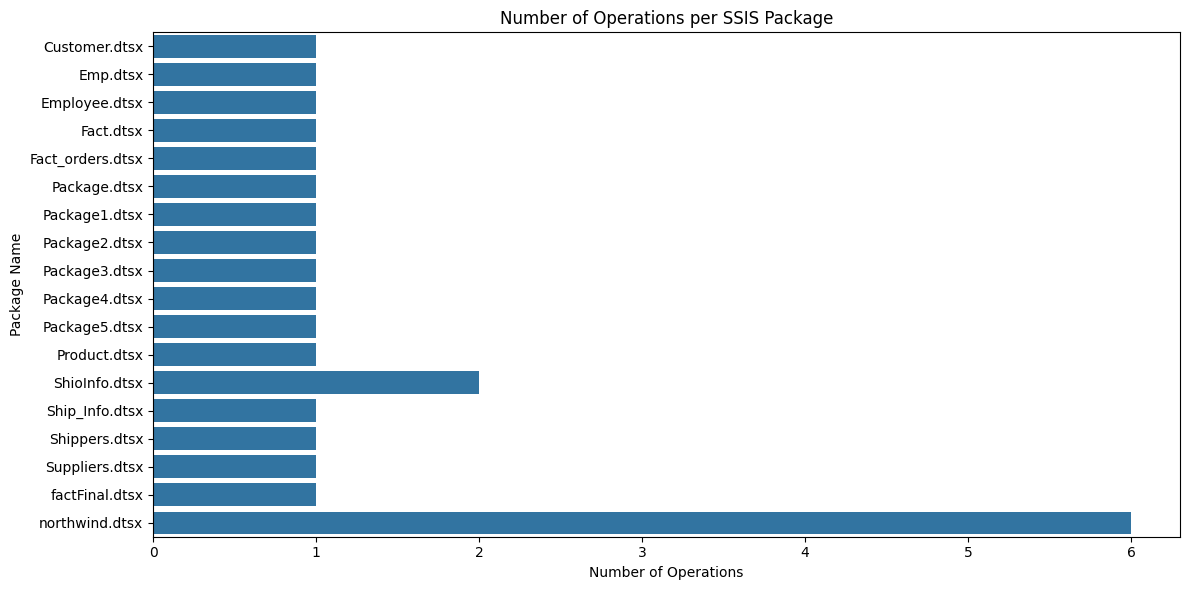


📊 Operation Count Statistics:
Total Operations: 24
Average Operations per Package: 1.3
Package with Most Operations: northwind.dtsx (6 ops)


In [19]:
# Create a visualization of packages and their operation counts
if not operations_df.empty:
    ops_per_package = operations_df.groupby('package_name').size().reset_index(name='operation_count')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=ops_per_package, x='operation_count', y='package_name')
    plt.title('Number of Operations per SSIS Package')
    plt.xlabel('Number of Operations')
    plt.ylabel('Package Name')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Operation Count Statistics:")
    print(f"Total Operations: {len(operations_df)}")
    print(f"Average Operations per Package: {ops_per_package['operation_count'].mean():.1f}")
    print(f"Package with Most Operations: {ops_per_package.loc[ops_per_package['operation_count'].idxmax(), 'package_name']} ({ops_per_package['operation_count'].max()} ops)")

## Part 3: Data Assets and Tables

In [ ]:
# Explore tables and verify Categories table extraction fix
tables_df = execute_query(
    """MATCH (t:Node {node_type: 'table'})
       RETURN t.name as table_name, 
              t.id as table_id,
              t.properties as properties
       ORDER BY t.name""",
    "Data assets and tables in the enhanced SSIS graph"
)

print(f"\n🗃️ Found {len(tables_df)} tables/data assets:")

# Check for Categories table specifically (the key fix)
categories_found = any('Categories' in table['table_name'] for _, table in tables_df.iterrows())
products_found = any('Products' in table['table_name'] for _, table in tables_df.iterrows())

print(f"\n✅ KEY MIGRATION TABLES:")
print(f"  • Categories table: {'✅ Found' if categories_found else '❌ Missing (Original Issue)'}")
print(f"  • Products table: {'✅ Found' if products_found else '❌ Missing'}")

if categories_found and products_found:
    print(f"  🎉 Categories extraction fix WORKING! Ready for JOIN analysis.")
else:
    print(f"  ⚠️  Issue detected: Missing key tables for migration")

print(f"\n📋 All Tables:")
if not tables_df.empty:
    for _, table in tables_df.iterrows():
        table_name = table['table_name']
        status_icon = "🎯" if 'Categories' in table_name or 'Products' in table_name else "📄"
        print(f"  {status_icon} {table_name}")

display(tables_df[['table_name', 'table_id']])

## Part 4: Data Flow Analysis

In [21]:
# Analyze data flows (operations reading from or writing to tables)
data_flows_df = execute_query(
    """MATCH (op:Node {node_type: 'operation'})-[r:READS_FROM|WRITES_TO]->(table:Node {node_type: 'table'})
       RETURN op.name as operation_name,
              type(r) as flow_type,
              table.name as table_name
       ORDER BY table.name, op.name""",
    "Data flows between operations and tables"
)

if not data_flows_df.empty:
    print(f"\n💾 Data Flow Summary:")
    flow_summary = data_flows_df['flow_type'].value_counts()
    for flow_type, count in flow_summary.items():
        print(f"  • {flow_type}: {count} connections")
    
    print(f"\n🔄 Sample Data Flows:")
    for _, flow in data_flows_df.head(10).iterrows():
        print(f"  • {flow['operation_name']} --[{flow['flow_type']}]--> {flow['table_name']}")

display(data_flows_df.head(15))


🔍 Data flows between operations and tables
Query: MATCH (op:Node {node_type: 'operation'})-[r:READS_FROM|WRITES_TO]->(table:Node {node_type: 'table'})
       RETURN op.name as operation_name,
              type(r) as flow_type,
              table.name as table_name
       ORDER BY table.name, op.name
--------------------------------------------------
Found 53 results

💾 Data Flow Summary:
  • READS_FROM: 29 connections
  • WRITES_TO: 24 connections

🔄 Sample Data Flows:
  • Data Flow Fact_Table --[READS_FROM]--> dbo.Orders
  • Data Flow Orders_Fact --[READS_FROM]--> dbo.Orders
  • Data Flow Task --[READS_FROM]--> dbo.Orders
  • Data Flow Task_ship info --[READS_FROM]--> dbo.Orders
  • Data Flow Task_ship info --[READS_FROM]--> dbo.Orders
  • Data Flow Task_ship info --[READS_FROM]--> dbo.Orders
  • Data Flow Task_ship info --[READS_FROM]--> dbo.Orders
  • Data Flow Task_ship info --[READS_FROM]--> dbo.Orders
  • Data Flow Fact_Table --[READS_FROM]--> dbo.orders_fact
  • Data Flow Tas

,operation_name,flow_type,table_name
0,Data Flow Fact_Table,READS_FROM,dbo.Orders
1,Data Flow Orders_Fact,READS_FROM,dbo.Orders
2,Data Flow Task,READS_FROM,dbo.Orders
3,Data Flow Task_ship info,READS_FROM,dbo.Orders
4,Data Flow Task_ship info,READS_FROM,dbo.Orders
5,Data Flow Task_ship info,READS_FROM,dbo.Orders
6,Data Flow Task_ship info,READS_FROM,dbo.Orders
7,Data Flow Task_ship info,READS_FROM,dbo.Orders
8,Data Flow Fact_Table,READS_FROM,dbo.orders_fact
9,Data Flow Task,READS_FROM,dbo.orders_fact


In [22]:
# Find tables that are used by multiple operations (shared resources)
shared_tables_df = execute_query(
    """MATCH (op:Node {node_type: 'operation'})-[r:READS_FROM|WRITES_TO]->(table:Node {node_type: 'table'})
       WITH table, collect(DISTINCT op.name) as operations, count(DISTINCT op) as operation_count
       WHERE operation_count > 1
       RETURN table.name as table_name,
              operation_count,
              operations
       ORDER BY operation_count DESC""",
    "Tables shared by multiple operations (potential bottlenecks)"
)

if not shared_tables_df.empty:
    print(f"\n⚠️ Shared Tables (Potential Bottlenecks):")
    for _, table in shared_tables_df.iterrows():
        print(f"  • {table['table_name']}: used by {table['operation_count']} operations")
        operations_list = table['operations'][:3]  # Show first 3 operations
        print(f"    Operations: {', '.join(operations_list)}{'...' if len(table['operations']) > 3 else ''}")
        print()

display(shared_tables_df)


🔍 Tables shared by multiple operations (potential bottlenecks)
Query: MATCH (op:Node {node_type: 'operation'})-[r:READS_FROM|WRITES_TO]->(table:Node {node_type: 'table'})
       WITH table, collect(DISTINCT op.name) as operations, count(DISTINCT op) as operation_count
       WHERE operation_count > 1
       RETURN table.name as table_name,
              operation_count,
              operations
       ORDER BY operation_count DESC
--------------------------------------------------
Found 15 results

⚠️ Shared Tables (Potential Bottlenecks):
  • dbo.Orders: used by 8 operations
    Operations: Data Flow Orders_Fact, Data Flow Task_ship info, Data Flow Fact_Table...

  • dbo].[customer_dim: used by 7 operations
    Operations: Data Flow Task_ Customer, Data Flow Task_ship info

  • dbo].[ship_info: used by 5 operations
    Operations: Data Flow Task_ship info

  • dbo].[employee_dim: used by 4 operations
    Operations: Data Flow Task_Employee, Data Flow Task

  • dbo].[Employees: used b

,table_name,operation_count,operations
0,dbo.Orders,8,"[Data Flow Orders_Fact, Data Flow Task_ship in..."
1,dbo].[customer_dim,7,"[Data Flow Task_ Customer, Data Flow Task_ship..."
2,dbo].[ship_info,5,[Data Flow Task_ship info]
3,dbo].[employee_dim,4,"[Data Flow Task_Employee, Data Flow Task]"
4,dbo].[Employees,4,"[Data Flow Task_Employee, Data Flow Task]"
5,dbo].[Products,3,"[Data Flow Product, Data Flow Task]"
6,dbo].[Customers,3,[Data Flow Task_ Customer]
7,dbo].[Shippers,3,[Data Flow Task_Shippers]
8,dbo].[product_dim,3,"[Data Flow Product, Data Flow Task]"
9,dbo].[shipper_dim,3,[Data Flow Task_Shippers]


## Part 5: Package Dependencies

In [23]:
# Look for cross-package dependencies
cross_package_deps_df = execute_query(
    """MATCH (pkg1:Node {node_type: 'pipeline'})-[r:DEPENDS_ON]->(pkg2:Node {node_type: 'pipeline'})
       RETURN pkg1.name as dependent_package,
              pkg2.name as dependency_package,
              type(r) as relationship_type
       ORDER BY pkg1.name""",
    "Cross-package dependencies"
)

if not cross_package_deps_df.empty:
    print(f"\n🔗 Cross-Package Dependencies:")
    for _, dep in cross_package_deps_df.iterrows():
        print(f"  • {dep['dependent_package']} depends on {dep['dependency_package']}")
    
    display(cross_package_deps_df)
else:
    print("\n🔗 No direct cross-package dependencies found.")
    print("This could mean packages are independent or dependencies are implicit through shared resources.")


🔍 Cross-package dependencies
Query: MATCH (pkg1:Node {node_type: 'pipeline'})-[r:DEPENDS_ON]->(pkg2:Node {node_type: 'pipeline'})
       RETURN pkg1.name as dependent_package,
              pkg2.name as dependency_package,
              type(r) as relationship_type
       ORDER BY pkg1.name
--------------------------------------------------
No results found.

🔗 No direct cross-package dependencies found.
This could mean packages are independent or dependencies are implicit through shared resources.


In [10]:
# Alternative: Look for implicit dependencies through shared tables
implicit_deps_df = execute_query(
    """MATCH (pkg1:Node {node_type: 'pipeline'})-[:CONTAINS]->(op1:Node {node_type: 'operation'})-[:WRITES_TO]->(table:Node {node_type: 'table'})<-[:READS_FROM]-(op2:Node {node_type: 'operation'})<-[:CONTAINS]-(pkg2:Node {node_type: 'pipeline'})
       WHERE pkg1.name <> pkg2.name
       RETURN DISTINCT pkg1.name as writer_package,
              pkg2.name as reader_package,
              table.name as shared_table
       ORDER BY shared_table, writer_package""",
    "Implicit dependencies through shared tables"
)

if not implicit_deps_df.empty:
    print(f"\n🔄 Implicit Dependencies (via shared tables):")
    for _, dep in implicit_deps_df.head(10).iterrows():
        print(f"  • {dep['writer_package']} writes to {dep['shared_table']}, read by {dep['reader_package']}")
    
    display(implicit_deps_df.head(10))
else:
    print("\n🔄 No implicit dependencies through shared tables found.")


🔍 Implicit dependencies through shared tables
Query: MATCH (pkg1:Node {node_type: 'pipeline'})-[:CONTAINS]->(op1:Node {node_type: 'operation'})-[:WRITES_TO]->(table:Node {node_type: 'table'})<-[:READS_FROM]-(op2:Node {node_type: 'operation'})<-[:CONTAINS]-(pkg2:Node {node_type: 'pipeline'})
       WHERE pkg1.name <> pkg2.name
       RETURN DISTINCT pkg1.name as writer_package,
              pkg2.name as reader_package,
              table.name as shared_table
       ORDER BY shared_table, writer_package
--------------------------------------------------
Found 10 results

🔄 Implicit Dependencies (via shared tables):
  • Customer.dtsx writes to dbo].[customer_dim, read by Ship_Info.dtsx
  • Customer.dtsx writes to dbo].[customer_dim, read by northwind.dtsx
  • Customer.dtsx writes to dbo].[customer_dim, read by Package4.dtsx
  • Customer.dtsx writes to dbo].[customer_dim, read by ShioInfo.dtsx
  • ShioInfo.dtsx writes to dbo].[customer_dim, read by Ship_Info.dtsx
  • ShioInfo.dtsx write

,writer_package,reader_package,shared_table
0,Customer.dtsx,Ship_Info.dtsx,dbo].[customer_dim
1,Customer.dtsx,northwind.dtsx,dbo].[customer_dim
2,Customer.dtsx,Package4.dtsx,dbo].[customer_dim
3,Customer.dtsx,ShioInfo.dtsx,dbo].[customer_dim
4,ShioInfo.dtsx,Ship_Info.dtsx,dbo].[customer_dim
5,ShioInfo.dtsx,northwind.dtsx,dbo].[customer_dim
6,ShioInfo.dtsx,Package4.dtsx,dbo].[customer_dim
7,northwind.dtsx,Ship_Info.dtsx,dbo].[customer_dim
8,northwind.dtsx,Package4.dtsx,dbo].[customer_dim
9,northwind.dtsx,ShioInfo.dtsx,dbo].[customer_dim


## Part 6: Connection Analysis

In [11]:
# Analyze database connections
connections_df = execute_query(
    """MATCH (c:Node {node_type: 'connection'})
       RETURN c.name as connection_name,
              c.id as connection_id,
              c.properties as properties
       ORDER BY c.name""",
    "Database connections in the SSIS graph"
)

print(f"\n🔌 Found {len(connections_df)} connections:")
if not connections_df.empty:
    for _, conn in connections_df.iterrows():
        print(f"  • {conn['connection_name']}")
    
    display(connections_df[['connection_name', 'connection_id']])
else:
    print("No explicit connection nodes found.")
    print("Connections might be embedded in operation properties.")


🔍 Database connections in the SSIS graph
Query: MATCH (c:Node {node_type: 'connection'})
       RETURN c.name as connection_name,
              c.id as connection_id,
              c.properties as properties
       ORDER BY c.name
--------------------------------------------------
No results found.

🔌 Found 0 connections:
No explicit connection nodes found.
Connections might be embedded in operation properties.


In [ ]:
# Find operations that use connections
op_connections_df = execute_query(
    """MATCH (op:Node {node_type: 'operation'})-[r:USES_CONNECTION]->(conn:Node {node_type: 'connection'})
       RETURN op.name as operation_name,
              conn.name as connection_name,
              type(r) as relationship_type
       ORDER BY conn.name, op.name""",
    "Operations using database connections"
)

if not op_connections_df.empty:
    print(f"\n🔗 Operation-Connection Relationships:")
    conn_usage = op_connections_df.groupby('connection_name').size().reset_index(name='usage_count')
    
    for _, usage in conn_usage.iterrows():
        print(f"  • {usage['connection_name']}: used by {usage['usage_count']} operations")
    
    display(op_connections_df.head(10))
else:
    print("\n🔗 No explicit operation-connection relationships found.")
    print("This is normal if connections are embedded within operations.")

## Part 7: Graph Structure Summary

In [ ]:
# Create a comprehensive summary of the SSIS graph structure
print("📊 SSIS Northwind Graph Structure Summary")
print("=" * 50)

# Node counts by type
node_summary_df = execute_query(
    "MATCH (n) RETURN n.node_type as node_type, count(n) as count ORDER BY count DESC"
)

print("\n📦 Node Types:")
total_nodes = 0
for _, row in node_summary_df.iterrows():
    if row['node_type'] not in ['materialized_view', 'graph_metadata']:  # Exclude analytics nodes
        print(f"  • {row['node_type']}: {row['count']} nodes")
        total_nodes += row['count']

# Relationship counts
rel_summary_df = execute_query(
    "MATCH ()-[r]->() RETURN type(r) as relationship_type, count(r) as count ORDER BY count DESC"
)

print("\n🔗 Relationship Types:")
total_relationships = 0
for _, row in rel_summary_df.iterrows():
    print(f"  • {row['relationship_type']}: {row['count']} relationships")
    total_relationships += row['count']

print(f"\n📈 Totals:")
print(f"  • Total SSIS Nodes: {total_nodes}")
print(f"  • Total Relationships: {total_relationships}")
print(f"  • Graph Density: {total_relationships / (total_nodes * (total_nodes - 1)):.4f}" if total_nodes > 1 else "  • Graph Density: N/A")

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Node types pie chart
ssis_nodes = node_summary_df[~node_summary_df['node_type'].isin(['materialized_view', 'graph_metadata'])]
ax1.pie(ssis_nodes['count'], labels=ssis_nodes['node_type'], autopct='%1.1f%%', startangle=90)
ax1.set_title('SSIS Node Types Distribution')

# Relationship types bar chart
sns.barplot(data=rel_summary_df, x='count', y='relationship_type', ax=ax2)
ax2.set_title('Relationship Types Count')
ax2.set_xlabel('Number of Relationships')

plt.tight_layout()
plt.show()

## Next Steps

Now that you understand the SSIS graph structure, you can:

1. **Explore Analytics-Ready Features** - Open `03_analytics_ready_features.ipynb` to learn about materialized views
2. **Advanced Queries** - Open `04_advanced_queries.ipynb` for complex analysis patterns
3. **Migration Analysis** - Open `05_migration_analysis.ipynb` for practical migration scenarios

## Key Takeaways

- SSIS packages are represented as `pipeline` nodes
- Operations within packages are `operation` nodes connected via `CONTAINS` relationships
- Data flows are modeled as `READS_FROM` and `WRITES_TO` relationships
- Shared resources (tables used by multiple operations) can indicate potential bottlenecks
- The graph structure reflects the actual SSIS package architecture

In [ ]:
print("🤖 MIGRATION AGENT DATA CONSUMPTION GUIDE")
print("=" * 60)

# Summary for migration agents
migration_summary = {
    "total_packages": len(execute_query("MATCH (p:Node {node_type: 'pipeline'}) RETURN count(p) as count").iloc[0]) if not execute_query("MATCH (p:Node {node_type: 'pipeline'}) RETURN count(p) as count").empty else 0,
    "total_operations": len(execute_query("MATCH (op:Node {node_type: 'operation'}) RETURN count(op) as count").iloc[0]) if not execute_query("MATCH (op:Node {node_type: 'operation'}) RETURN count(op) as count").empty else 0,
    "total_tables": len(execute_query("MATCH (t:Node {node_type: 'table'}) RETURN count(t) as count").iloc[0]) if not execute_query("MATCH (t:Node {node_type: 'table'}) RETURN count(t) as count").empty else 0,
    "sql_semantics_operations": len(execute_query("MATCH (op:Node {node_type: 'operation'}) WHERE op.properties CONTAINS 'sql_semantics' RETURN count(op) as count").iloc[0]) if not execute_query("MATCH (op:Node {node_type: 'operation'}) WHERE op.properties CONTAINS 'sql_semantics' RETURN count(op) as count").empty else 0,
    "join_relationships": len(execute_query("MATCH ()-[r]->() WHERE r.properties CONTAINS 'join_type' RETURN count(r) as count").iloc[0]) if not execute_query("MATCH ()-[r]->() WHERE r.properties CONTAINS 'join_type' RETURN count(r) as count").empty else 0
}

print(f"📊 MIGRATION READINESS METRICS:")
print(f"  • Total SSIS Packages: {migration_summary['total_packages']}")
print(f"  • Total Operations: {migration_summary['total_operations']}")
print(f"  • Total Tables: {migration_summary['total_tables']}")
print(f"  • Operations with SQL Semantics: {migration_summary['sql_semantics_operations']}")
print(f"  • JOIN Relationships: {migration_summary['join_relationships']}")

# Calculate migration readiness score
readiness_score = 0
max_score = 5

if migration_summary['total_tables'] > 0:
    readiness_score += 1
if migration_summary['sql_semantics_operations'] > 0:
    readiness_score += 2  # Most important
if migration_summary['join_relationships'] > 0:
    readiness_score += 1
    
# Check for Categories table
categories_check = execute_query("MATCH (t:Node {node_type: 'table'}) WHERE t.name CONTAINS 'Categories' RETURN count(t) as count")
categories_found = categories_check.iloc[0]['count'] if not categories_check.empty else 0
if categories_found > 0:
    readiness_score += 1

print(f"\n🎯 MIGRATION READINESS SCORE: {readiness_score}/{max_score}")

if readiness_score >= 4:
    print(f"✅ EXCELLENT: Graph is ready for automated migration!")
    print(f"   Recommended platforms: Spark, dbt, Pandas")
elif readiness_score >= 2:
    print(f"⚠️ PARTIAL: Some migration automation possible")
    print(f"   Manual intervention may be needed")
else:
    print(f"❌ LIMITED: Significant manual work required")
    print(f"   Consider re-running analysis with enhanced parser")

print(f"\n📋 MIGRATION AGENT QUERIES:")
print(f"Use these queries to extract migration-critical data:")
print(f"""
1. Get operations with SQL semantics:
   MATCH (op:Node {{node_type: 'operation'}})
   WHERE op.properties CONTAINS 'sql_semantics'
   RETURN op.name, op.properties

2. Find JOIN relationships:
   MATCH (t1)-[r:REFERENCES]->(t2)
   WHERE r.properties CONTAINS 'join_type'
   RETURN t1.name, t2.name, r.properties

3. Get all tables for platform mapping:
   MATCH (t:Node {{node_type: 'table'}})
   RETURN t.name, t.properties

4. Find package dependencies:
   MATCH (pkg1)-[:CONTAINS]->(op1)-[:WRITES_TO]->(table)<-[:READS_FROM]-(op2)<-[:CONTAINS]-(pkg2)
   WHERE pkg1.name <> pkg2.name
   RETURN DISTINCT pkg1.name, pkg2.name, table.name
""")

## 🎯 MIGRATION AGENT SUMMARY

This section provides a summary specifically designed for migration agents that need to consume this graph data for automated code generation.

In [ ]:
# Find JOIN relationships in the graph (enhanced metadata)
join_edges_df = execute_query(
    """MATCH (t1:Node {node_type: 'table'})-[r:REFERENCES]->(t2:Node {node_type: 'table'})
       WHERE r.properties CONTAINS 'join_type'
       RETURN t1.name as left_table,
              t2.name as right_table,
              r.properties as join_metadata
       ORDER BY t1.name""",
    "JOIN relationships stored as graph edges (migration-critical)"
)

print(f"\n🔗 Found {len(join_edges_df)} JOIN relationships as graph edges:")

if not join_edges_df.empty:
    for _, join_edge in join_edges_df.iterrows():
        properties = json.loads(join_edge['join_metadata']) if isinstance(join_edge['join_metadata'], str) else join_edge['join_metadata']
        
        join_type = properties.get('join_type', 'UNKNOWN')
        condition = properties.get('condition', 'N/A')
        left_alias = properties.get('left_alias', '')
        right_alias = properties.get('right_alias', '')
        
        left_display = f"{join_edge['left_table']} ({left_alias})" if left_alias else join_edge['left_table']
        right_display = f"{join_edge['right_table']} ({right_alias})" if right_alias else join_edge['right_table']
        
        print(f"  🔗 {left_display} {join_type} {right_display}")
        print(f"     Condition: {condition}")
        print()
        
    print(f"✅ JOIN EDGE VALIDATION:")
    products_categories_join = any(
        ('Products' in row['left_table'] and 'Categories' in row['right_table']) or
        ('Categories' in row['left_table'] and 'Products' in row['right_table'])
        for _, row in join_edges_df.iterrows()
    )
    
    if products_categories_join:
        print(f"  🎉 Products ↔ Categories JOIN found in graph!")
        print(f"  ✅ Critical relationship captured for migration")
    else:
        print(f"  ⚠️ Products ↔ Categories JOIN not found as edge")
        print(f"  💡 Check SQL semantics metadata instead")
else:
    print("❌ No JOIN relationships found as graph edges.")
    print("💡 JOINs may be stored in operation SQL semantics metadata instead.")

display(join_edges_df)

In [ ]:
# Find operations with SQL semantics metadata
sql_ops_df = execute_query(
    """MATCH (op:Node {node_type: 'operation'})
       WHERE op.properties CONTAINS 'sql_semantics'
       RETURN op.name as operation_name,
              op.id as operation_id,
              op.properties as properties
       ORDER BY op.name""",
    "Operations with SQL semantics metadata (migration-ready)"
)

print(f"\n🚀 Found {len(sql_ops_df)} operations with SQL semantics:")

if not sql_ops_df.empty:
    for _, op in sql_ops_df.iterrows():
        print(f"  • {op['operation_name']}")
    
    # Focus on the Product operation (our key example)
    product_ops = sql_ops_df[sql_ops_df['operation_name'].str.contains('Product', case=False)]
    
    if not product_ops.empty:
        print(f"\n🎯 DETAILED ANALYSIS: Product Operation SQL Semantics")
        print("=" * 60)
        
        product_op = product_ops.iloc[0]
        properties = json.loads(product_op['properties']) if isinstance(product_op['properties'], str) else product_op['properties']
        
        if 'sql_semantics' in properties:
            sql_semantics = properties['sql_semantics']
            
            print(f"Operation: {product_op['operation_name']}")
            print(f"Original SQL: {sql_semantics.get('original_query', 'N/A')[:100]}...")
            print(f"Tables: {len(sql_semantics.get('tables', []))}")
            print(f"Joins: {len(sql_semantics.get('joins', []))}")
            print(f"Columns: {len(sql_semantics.get('columns', []))}")
            
            # Show tables
            if sql_semantics.get('tables'):
                print(f"\n📋 Tables in SQL:")
                for table in sql_semantics['tables']:
                    alias_info = f" (alias: {table['alias']})" if table.get('alias') else ""
                    schema_info = f" [schema: {table['schema']}]" if table.get('schema') else ""
                    print(f"  • {table['name']}{alias_info}{schema_info}")
            
            # Show JOIN relationships
            if sql_semantics.get('joins'):
                print(f"\n🔗 JOIN Relationships:")
                for join in sql_semantics['joins']:
                    left = f"{join['left_table']['name']} ({join['left_table']['alias']})"
                    right = f"{join['right_table']['name']} ({join['right_table']['alias']})"
                    print(f"  • {left} {join['join_type']} {right}")
                    print(f"    Condition: {join['condition']}")
            
            # Show column aliases
            aliases = [col for col in sql_semantics.get('columns', []) if col.get('alias')]
            if aliases:
                print(f"\n🏷️ Column Aliases (Critical for Migration):")
                for col in aliases[:5]:  # Show first 5
                    print(f"  • {col['expression']} AS {col['alias']}")
else:
    print("❌ No operations with SQL semantics found!")
    print("This indicates the enhanced parser integration may not be working.")

display(sql_ops_df[['operation_name', 'operation_id']])

# PART 8: SQL SEMANTICS EXPLORATION (MIGRATION-CRITICAL)

This section explores the enhanced SQL semantics metadata that's essential for migration agents.